In [2]:
import numpy as np

def boxcar_smooth(in_data, in_days, window=1):
    """
    Calculates exponentially filtered time series using
    a boxcar filter - basically a moving average calculation

    Parameters
    ----------
    in_data : double numpy.array
        input data
    in_jd : double numpy.array
        julian dates of input data
    window : int
        characteristic time used for calculating
        the weight
    nan : double
        nan values to exclude from calculation
    """
    filtered = np.empty(len(in_data))

    filtered.fill(np.nan)

    for i in range(in_days.shape[0]):
        sum = 0
        nobs = 0
        for j in range(in_days.shape[0]):
            tdiff = in_days[j] - in_days[i]
            if abs(tdiff) <= window/2:
                sum = sum + in_data[j]
                nobs = nobs + 1

        filtered[i] = sum/nobs

    return filtered

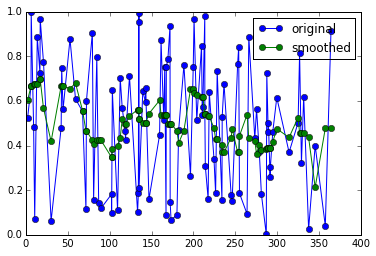

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

ts_values = np.random.rand(100)
ts_days = np.sort(np.random.rand(100) * 365 )
smoothed = boxcar_smooth(ts_values, ts_days, window=25)

plt.plot(ts_days, ts_values, 'o-', label='original')
plt.plot(ts_days, smoothed, 'o-', label='smoothed')
plt.legend()
plt.show()


Setup a calling function which we can easily use for profiling,

We will measure the overhead of array creation but this should be negligible

In [14]:
def run_smoother(func,n=1000, window=5):
    """
    Run a smoothing function
    """
    ts_values = np.random.rand(n)
    ts_days = np.sort(np.random.rand(n) * 365 )
    smoothed = func(ts_values, ts_days, window=window)

In [15]:
%timeit run_smoother(boxcar_smooth)

1 loops, best of 3: 417 ms per loop


In [19]:
# this is just so that ipython outputs into the 
# regular output
from __future__ import print_function
from IPython.core import page
page.page = print

%prun run_smoother(boxcar_smooth)

         1001015 function calls in 0.739 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.650    0.650    0.739    0.739 <ipython-input-2-26af37b36b2b>:3(boxcar_smooth)
  1000000    0.085    0.000    0.085    0.000 {abs}
     1001    0.005    0.000    0.005    0.000 {range}
        1    0.000    0.000    0.000    0.000 {method 'sort' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {method 'rand' of 'mtrand.RandomState' objects}
        1    0.000    0.000    0.739    0.739 <ipython-input-14-a62c3e3cec89>:1(run_smoother)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:694(sort)
        1    0.000    0.000    0.000    0.000 numeric.py:464(asanyarray)
        1    0.000    0.000    0.000    0.000 {method 'copy' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.739    0.739 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'fill' of 'numpy.

We can do this also in the command line to get rid of the overhead and get a outputfile for visualization.

In [76]:
!python -m cProfile -o smooth.prof smooth.py

Either use the pstats module of python

`!python -m pstats smooth.prof`

`sort cumulative`

`stats 10`

`quit`

or runsnake if installed

Line profiler can be used like this

`kernprof -l -o linebyline.prof smooth.py`

to view the results

`python -m line_profiler linebyline.prof`

In [25]:
%load_ext Cython

In [33]:
%%cython -a

cimport numpy as np
import numpy as np
cimport cython

def boxcar_smooth_cython1(np.ndarray[np.double_t, ndim=1] in_data, 
                  np.ndarray[np.double_t, ndim=1] in_days, float window=1):
    """
    Calculates exponentially filtered time series using
    a boxcar filter - basically a moving average calculation

    Parameters
    ----------
    in_data : double numpy.array
        input data
    in_jd : double numpy.array
        julian dates of input data
    window : int
        characteristic time used for calculating
        the weight
    nan : double
        nan values to exclude from calculation
    """
    cdef np.ndarray[np.double_t, ndim=1] filtered = np.empty(len(in_data))
    cdef double tdiff
    cdef unsigned int i
    cdef unsigned int j
    cdef double sum=0
    cdef int nobs=0
    filtered.fill(np.nan)

    for i in range(in_days.shape[0]):
        sum = 0
        nobs = 0
        for j in range(in_days.shape[0]):
            tdiff = in_days[j] - in_days[i]
            if abs(tdiff) <= window/2.0:
                sum = sum + in_data[j]
                nobs = nobs + 1
                
        filtered[i] = sum/nobs
        
    return filtered     


In [28]:
%timeit run_smoother(boxcar_smooth)

1 loops, best of 3: 438 ms per loop


In [29]:
%timeit run_smoother(boxcar_smooth_cython1)

100 loops, best of 3: 2.09 ms per loop


We see that it runs orders of magnitude faster but still a few yellow lines in the output remain.
This tells us that cython has to go back to the python level to do some checks.

These checks can be disabled using function decorators.

In [41]:
%%cython -a

cimport numpy as np
import numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def boxcar_smooth_cython2(np.ndarray[np.double_t, ndim=1] in_data, 
                  np.ndarray[np.double_t, ndim=1] in_days, float window=1):
    """
    Calculates exponentially filtered time series using
    a boxcar filter - basically a moving average calculation

    Parameters
    ----------
    in_data : double numpy.array
        input data
    in_jd : double numpy.array
        julian dates of input data
    window : int
        characteristic time used for calculating
        the weight
    nan : double
        nan values to exclude from calculation
    """
    cdef np.ndarray[np.double_t, ndim=1] filtered = np.empty(len(in_data))
    cdef double tdiff
    cdef unsigned int i
    cdef unsigned int j
    cdef double sum=0
    cdef int nobs=0
    filtered.fill(np.nan)

    for i in range(in_days.shape[0]):
        sum = 0
        nobs = 0
        for j in range(in_days.shape[0]):
            tdiff = in_days[j] - in_days[i]
            if abs(tdiff) <= window/2.0:
                sum = sum + in_data[j]
                nobs = nobs + 1
                
        filtered[i] = sum/nobs
        
    return filtered     

In [42]:
%timeit run_smoother(boxcar_smooth_cython2)

1000 loops, best of 3: 1.24 ms per loop


Let's try the same using numba

In [49]:
from numba import jit

@jit
def boxcar_smooth_numba(in_data, in_days, window=1):
    """
    Calculates exponentially filtered time series using
    a boxcar filter - basically a moving average calculation

    Parameters
    ----------
    in_data : double numpy.array
        input data
    in_jd : double numpy.array
        julian dates of input data
    window : int
        characteristic time used for calculating
        the weight
    nan : double
        nan values to exclude from calculation
    """
    filtered = np.empty(len(in_data))

    filtered.fill(np.nan)

    for i in range(in_days.shape[0]):
        sum = 0
        nobs = 0
        for j in range(in_days.shape[0]):
            tdiff = in_days[j] - in_days[i]
            if abs(tdiff) <= window/2:
                sum = sum + in_data[j]
                nobs = nobs + 1

        filtered[i] = sum/nobs

    return filtered

In [50]:
%timeit run_smoother(boxcar_smooth_numba)

The slowest run took 107.80 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 1.61 ms per loop


In the numba case the JIT (just in time) compiler had to run the program once, after that the compiled version was available. This causes the Warning abouth caching.

#Parallelization

The same code can be used by a script

First we have to start a IPython cluster. We can do this through the IPython interface in the "Home" tab under Clusters. Or in the command line by calling `ipcluster start -n 4` where `n` is the number of cores to use.

In [65]:
from IPython.parallel import Client
rc = Client()
dview = rc[:]

data = range(10)
def p10(x):
    return x**10
        
power10 = dview.map_sync(p10, data )

print(power10)

[0, 1, 1024, 59049, 1048576, 9765625, 60466176, 282475249, 1073741824, 3486784401]


In [74]:
data = range(1000000)
%time dview.map_sync(p10, data)

CPU times: user 211 ms, sys: 72 ms, total: 283 ms
Wall time: 570 ms


[0,
 1,
 1024,
 59049,
 1048576,
 9765625,
 60466176,
 282475249,
 1073741824,
 3486784401,
 10000000000,
 25937424601,
 61917364224,
 137858491849,
 289254654976,
 576650390625,
 1099511627776,
 2015993900449,
 3570467226624,
 6131066257801,
 10240000000000,
 16679880978201,
 26559922791424,
 41426511213649,
 63403380965376,
 95367431640625,
 141167095653376,
 205891132094649,
 296196766695424,
 420707233300201,
 590490000000000,
 819628286980801,
 1125899906842624,
 1531578985264449,
 2064377754059776,
 2758547353515625,
 3656158440062976,
 4808584372417849,
 6278211847988224,
 8140406085191601,
 10485760000000000,
 13422659310152401,
 17080198121677824,
 21611482313284249,
 27197360938418176,
 34050628916015625,
 42420747482776576,
 52599132235830049,
 64925062108545024,
 79792266297612001,
 97656250000000000,
 119042423827613001,
 144555105949057024,
 174887470365513049,
 210832519264920576,
 253295162119140625,
 303305489096114176,
 362033331456891249,
 430804206899405824,
 511116

In [75]:
%time [p10(x) for x in data]

CPU times: user 1.43 s, sys: 40.1 ms, total: 1.47 s
Wall time: 1.45 s


[0,
 1,
 1024,
 59049,
 1048576,
 9765625,
 60466176,
 282475249,
 1073741824,
 3486784401,
 10000000000,
 25937424601,
 61917364224,
 137858491849,
 289254654976,
 576650390625,
 1099511627776,
 2015993900449,
 3570467226624,
 6131066257801,
 10240000000000,
 16679880978201,
 26559922791424,
 41426511213649,
 63403380965376,
 95367431640625,
 141167095653376,
 205891132094649,
 296196766695424,
 420707233300201,
 590490000000000,
 819628286980801,
 1125899906842624,
 1531578985264449,
 2064377754059776,
 2758547353515625,
 3656158440062976,
 4808584372417849,
 6278211847988224,
 8140406085191601,
 10485760000000000,
 13422659310152401,
 17080198121677824,
 21611482313284249,
 27197360938418176,
 34050628916015625,
 42420747482776576,
 52599132235830049,
 64925062108545024,
 79792266297612001,
 97656250000000000,
 119042423827613001,
 144555105949057024,
 174887470365513049,
 210832519264920576,
 253295162119140625,
 303305489096114176,
 362033331456891249,
 430804206899405824,
 511116